**Assignment 1**

**GNR 650**

**22m2152 , 22m2159**

In [2]:

import torch
torch.cuda.is_available()
import pytorch_lightning as pl

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import torchvision.models as models
import wandb
import numpy as np
import random

from pytorch_lightning.loggers import WandbLogger
import torch.nn as nn

# Set seed for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

pl.seed_everything(42)
set_seed(42)

# Load and Subsample the CIFAR10 Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

indices = []
for i in range(10):  # 10 classes in CIFAR10
    class_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == i]
    indices.extend(class_indices[:100])

subsampled_train_dataset = torch.utils.data.Subset(train_dataset, indices)
train_loader = torch.utils.data.DataLoader(subsampled_train_dataset, batch_size=10, shuffle=True)

# Define the Lightning Module
class ResNet18Lightning(pl.LightningModule):
    def __init__(self, num_classes=10):
        super(ResNet18Lightning, self).__init__()
        self.resnet18 = models.resnet18(pretrained=False, num_classes=num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.test_outputs = []

    def forward(self, x):
        return self.resnet18(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
        output = {'test_loss': loss, 'test_acc': acc}
        self.test_outputs.append(output)
        return output

    def on_test_epoch_end(self):
        # Compute average loss and accuracy from stored outputs
        avg_loss = torch.stack([x['test_loss'] for x in self.test_outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in self.test_outputs]).mean()
        self.log('test_loss', avg_loss)
        self.log('test_acc', avg_acc)
        # Clear the test outputs for the next test run
        self.test_outputs = []

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.1, momentum=0.5, weight_decay=5e-4)
        return optimizer

# Train with wandb logging
wandb.init(project='resnet18_cifar10_subsampled_demo1')
wandb_logger = WandbLogger()

model = ResNet18Lightning().cuda()
trainer = pl.Trainer(max_epochs=40, accelerator="gpu" if torch.cuda.is_available() else "cpu", logger=wandb_logger)
trainer.fit(model, train_loader)
trainer.test(model, test_loader)

Global seed set to 42


Files already downloaded and verified


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 22m2159 (22m215). Use `wandb login --relogin` to force relogin


/home/cminds/miniconda3/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/home/cminds/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cminds/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Weight Magnitudes (L2 Norm) for each layer:
resnet18.conv1.weight: 9.9841
resnet18.bn1.weight: 7.9025
resnet18.bn1.bias: 0.4211
resnet18.layer1.0.conv1.weight: 11.9426
resnet18.layer1.0.bn1.weight: 7.8128
resnet18.layer1.0.bn1.bias: 0.2313
resnet18.layer1.0.conv2.weight: 11.7958
resnet18.layer1.0.bn2.weight: 7.7958
resnet18.layer1.0.bn2.bias: 0.2054
resnet18.layer1.1.conv1.weight: 11.6816
resnet18.layer1.1.bn1.weight: 7.8097
resnet18.layer1.1.bn1.bias: 0.1867
resnet18.layer1.1.conv2.weight: 11.5544
resnet18.layer1.1.bn2.weight: 7.7363
resnet18.layer1.1.bn2.bias: 0.1599
resnet18.layer2.0.conv1.weight: 11.9438
resnet18.layer2.0.bn1.weight: 11.0407
resnet18.layer2.0.bn1.bias: 0.2002
resnet18.layer2.0.conv2.weight: 16.2169
resnet18.layer2.0.bn2.weight: 10.9889
resnet18.layer2.0.bn2.bias: 0.1940
resnet18.layer2.0.downsample.0.weight: 11.1382
resnet18.layer2.0.downsample.1.weight: 11.0948
resnet18.layer2.0.downsample.1.bias: 0.1940
resnet18.layer2.1.conv1.weight: 16.1984
resnet18.layer2.1.bn

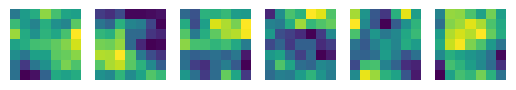

\nVisualizing kernels of the first convolutional layer (Improved):


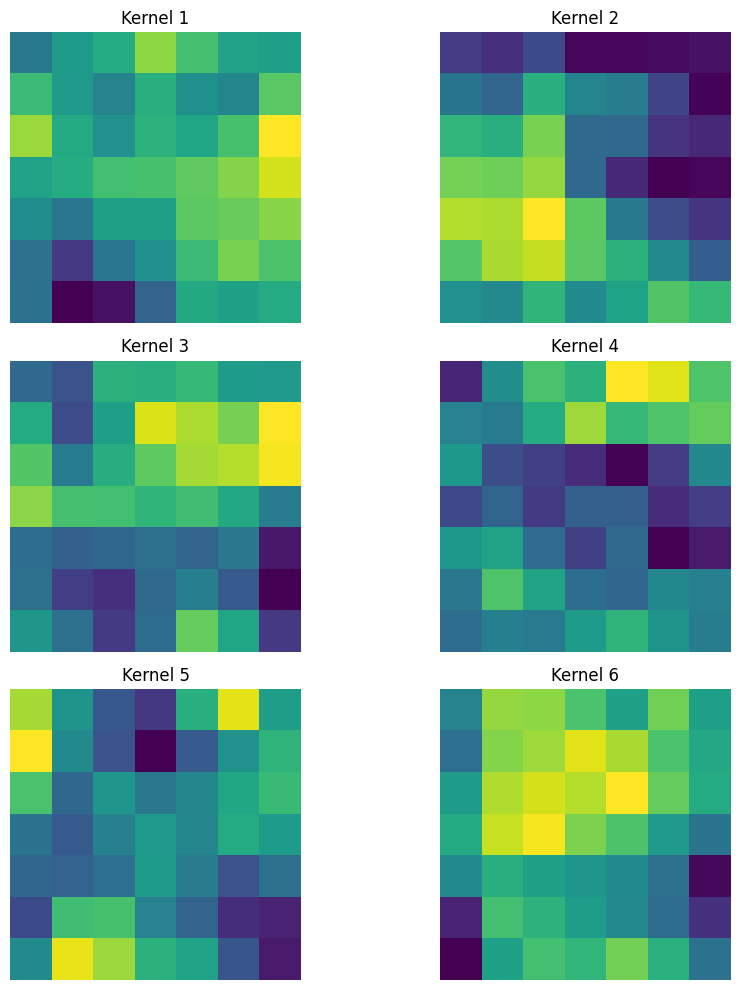

In [7]:


import matplotlib.pyplot as plt

# Assuming model is an instance of ResNet18Lightning

# 1. Check the Magnitudes of the Weights:

print("Weight Magnitudes (L2 Norm) for each layer:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {torch.norm(param.data):.4f}")

# 2. Visualize Kernels:

# def visualize_kernels(layer_weights, num_kernels=6):
#     # Assuming layer_weights is of shape (out_channels, in_channels, kernel_height, kernel_width)
#     for i in range(min(num_kernels, layer_weights.shape[0])):
#         plt.subplot(1, num_kernels, i + 1)
#         # Take the mean over all input channels to get a single 2D image for visualization
#         plt.imshow(layer_weights[i].mean(0).cpu().detach().numpy(), cmap='viridis')
#         plt.axis('off')
#     plt.show()

# Visualize the kernels of the first convolutional layer
print("\nVisualizing kernels of the first convolutional layer:")
first_layer_weights = model.resnet18.conv1.weight.data
visualize_kernels(first_layer_weights)

def visualize_kernels_improved(layer_weights, num_kernels=6, rows=3, cols=2):
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i in range(min(num_kernels, layer_weights.shape[0])):
        ax = axes[i // cols, i % cols]
        ax.imshow(layer_weights[i].mean(0).cpu().detach().numpy(), cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Kernel {i + 1}")
    plt.tight_layout()
    plt.show()
print("\\nVisualizing kernels of the first convolutional layer (Improved):")
first_layer_weights = model.resnet18.conv1.weight.data
visualize_kernels_improved(first_layer_weights)    

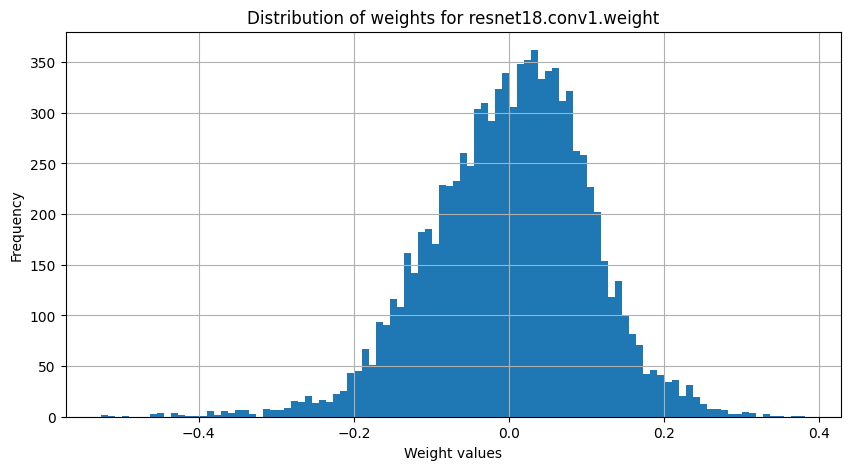

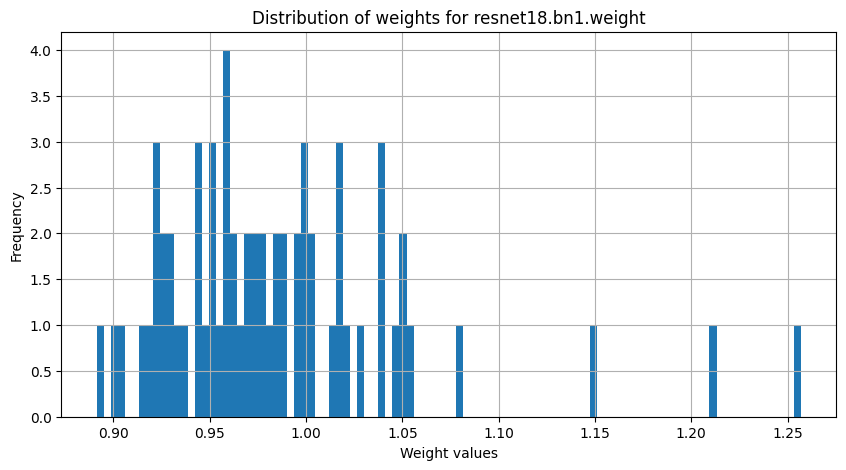

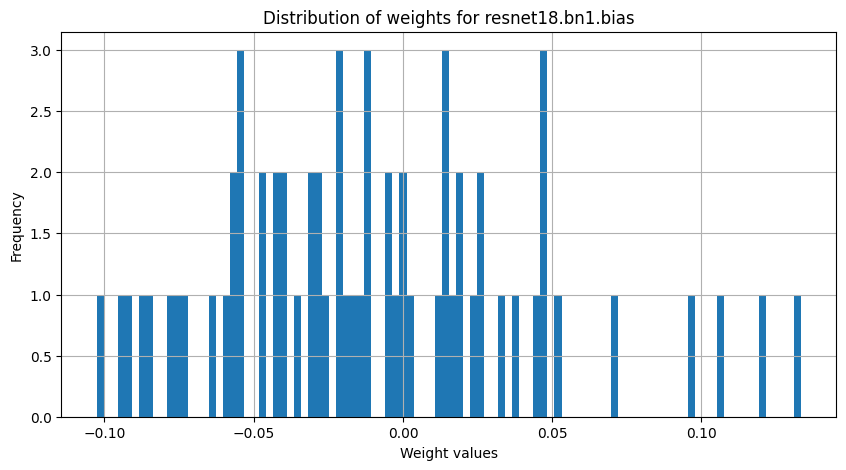

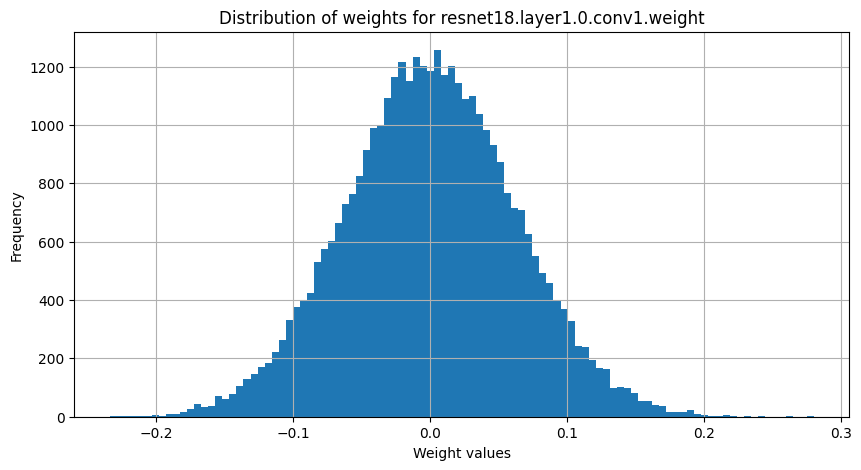

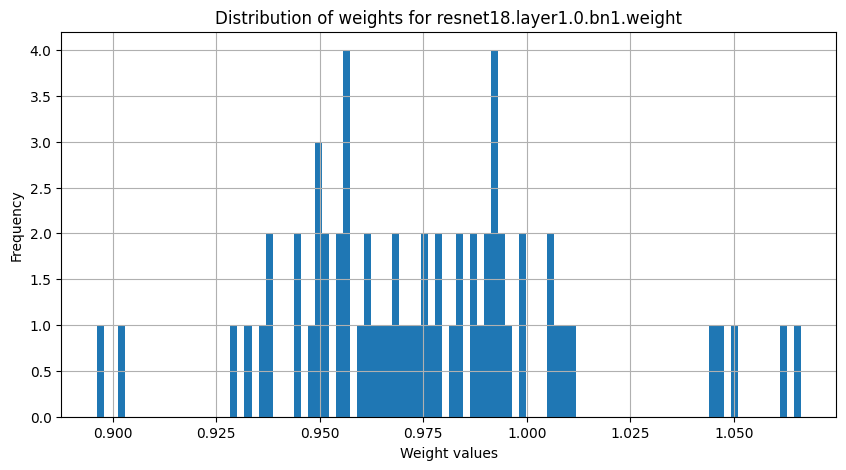

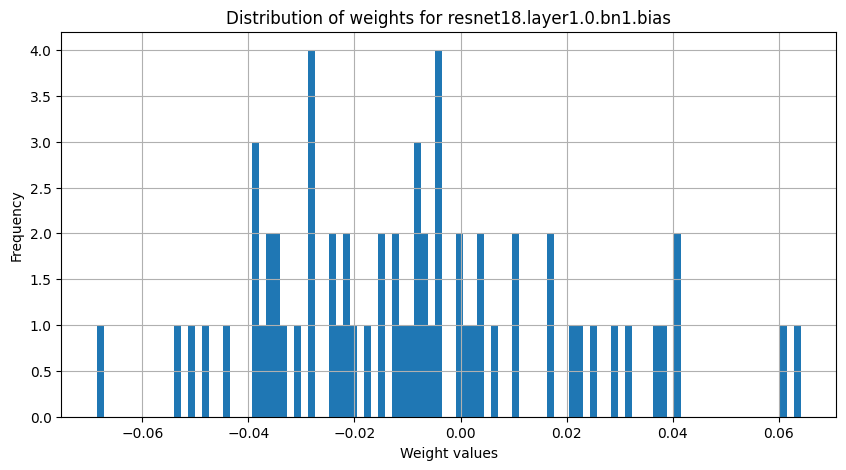

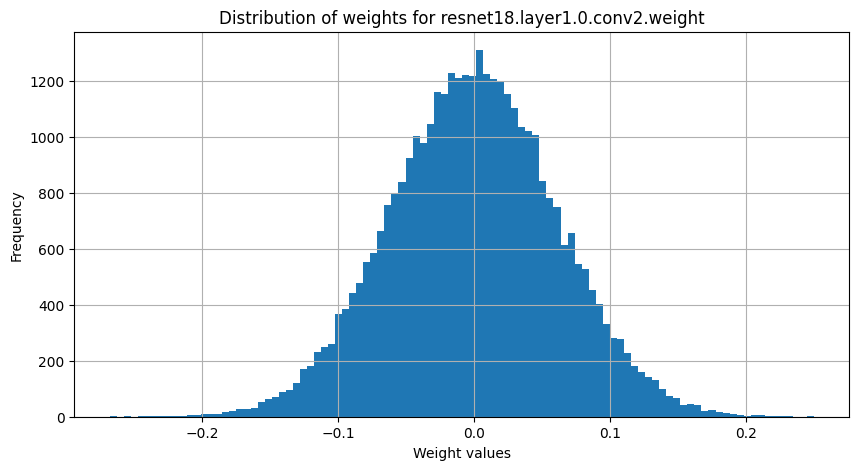

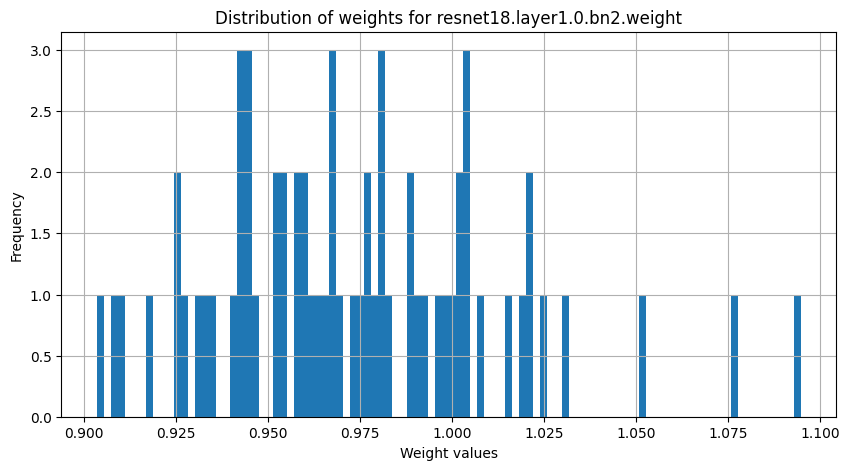

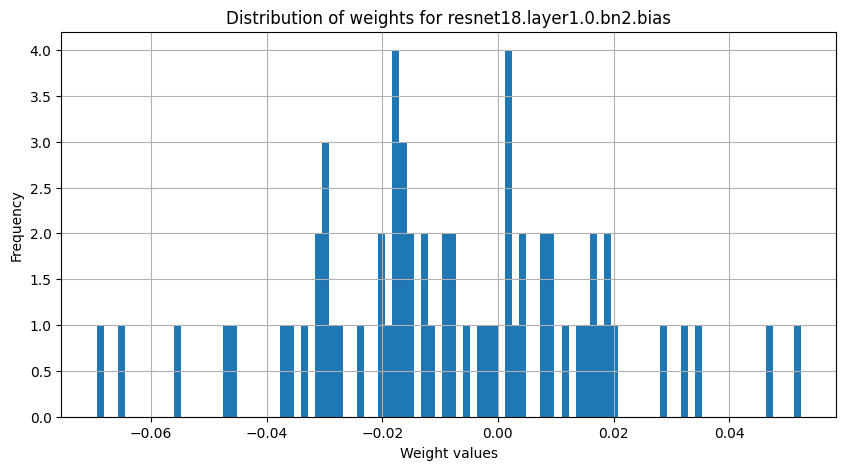

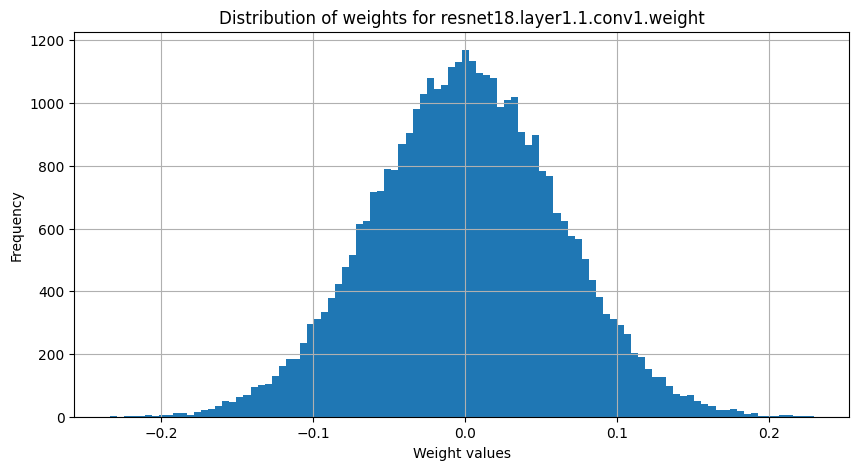

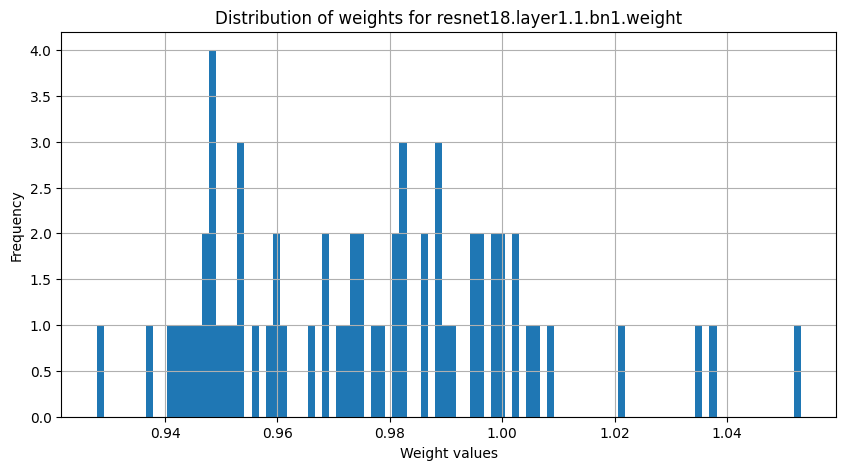

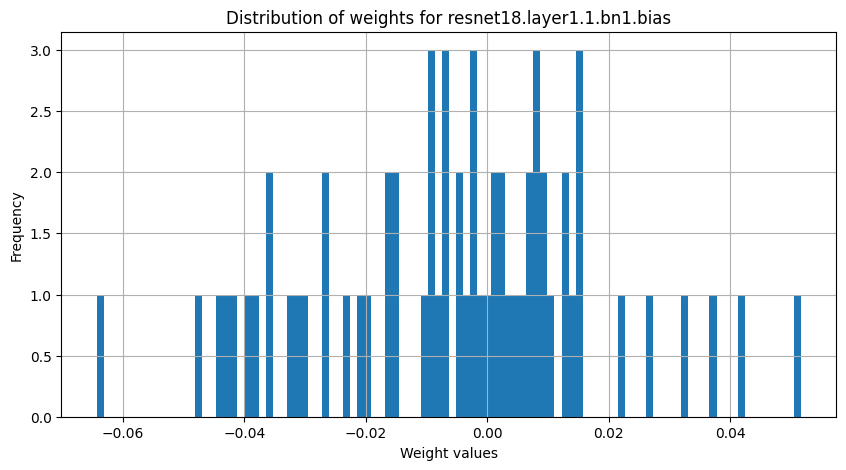

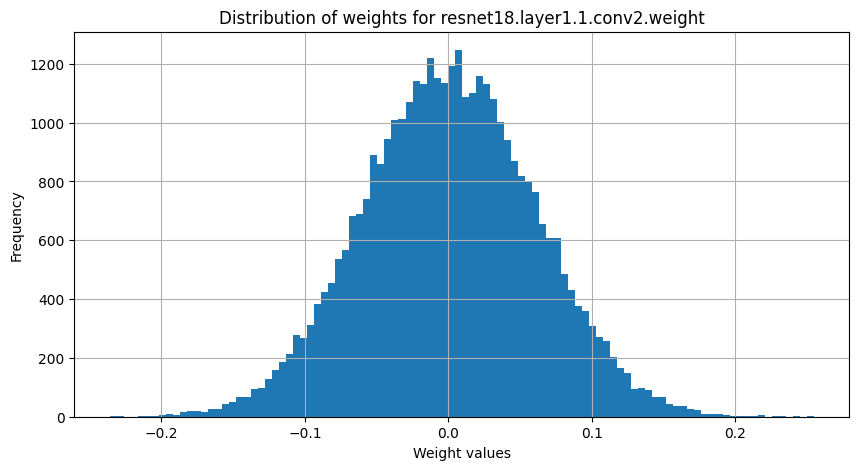

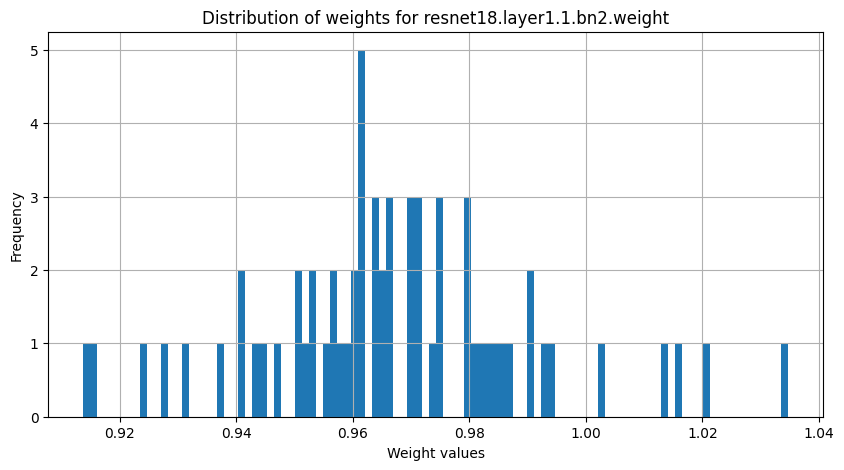

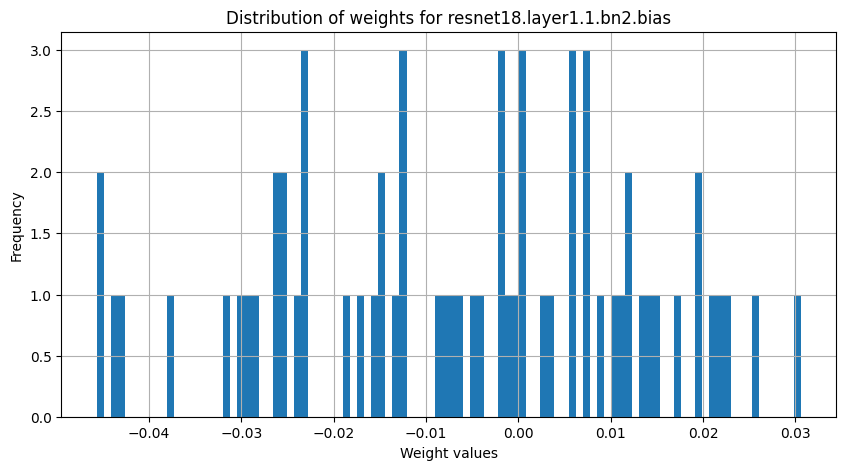

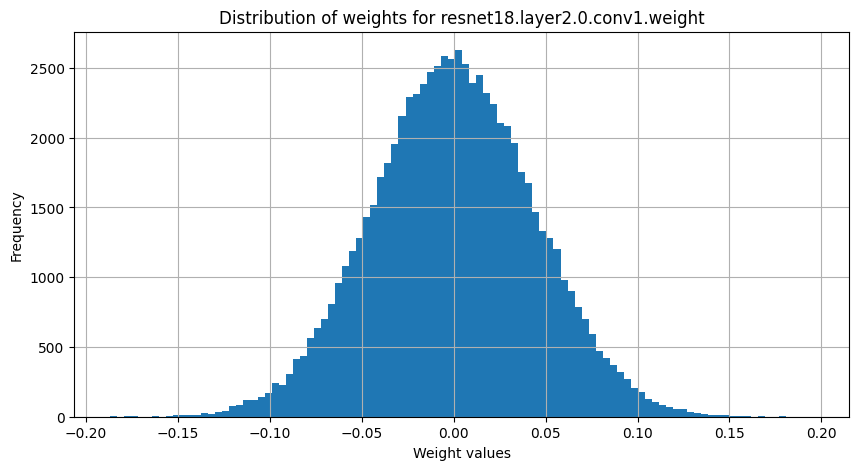

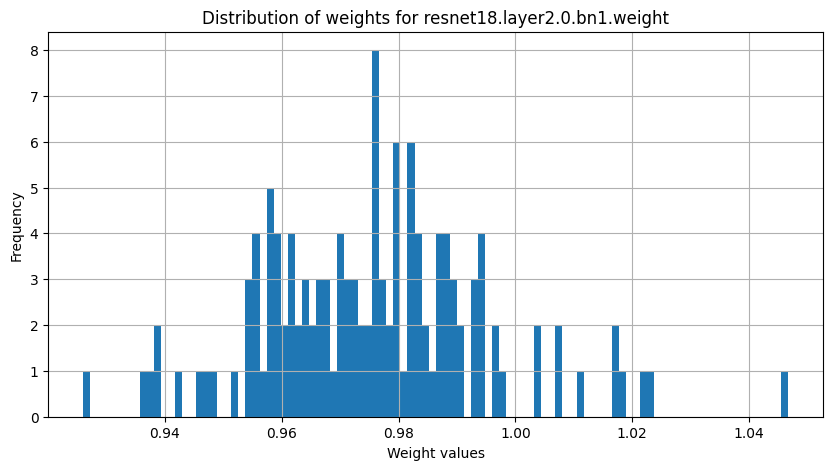

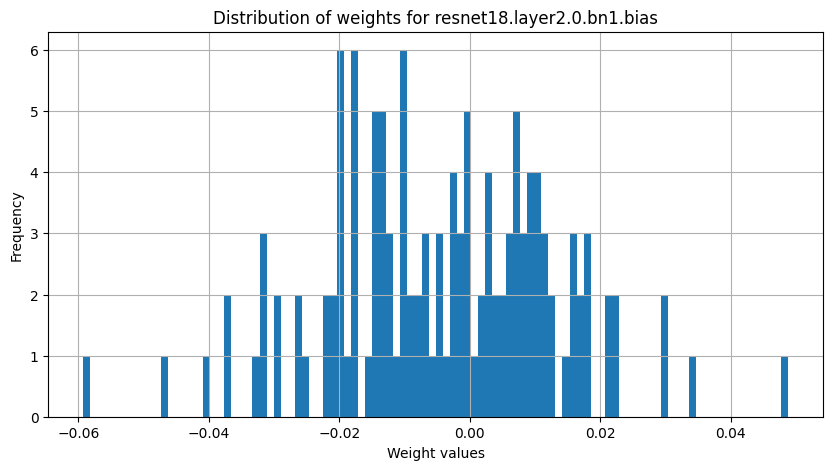

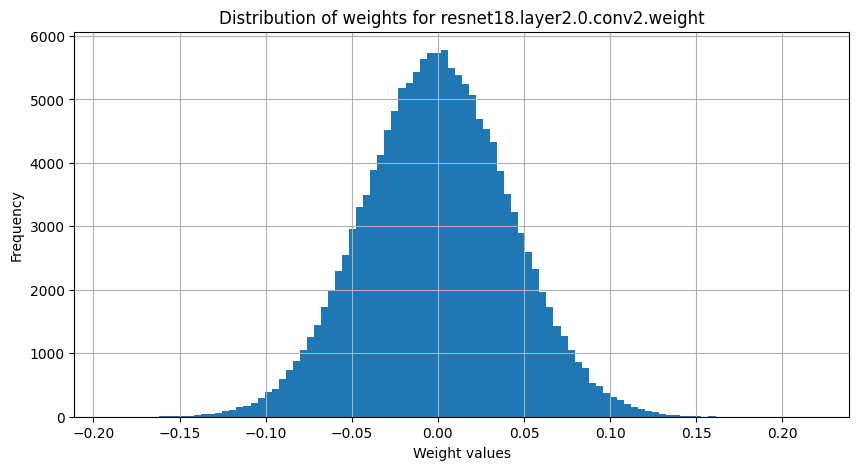

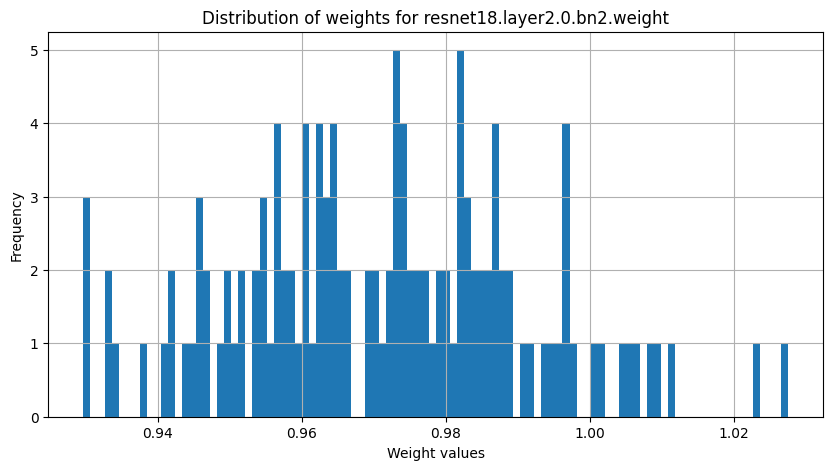

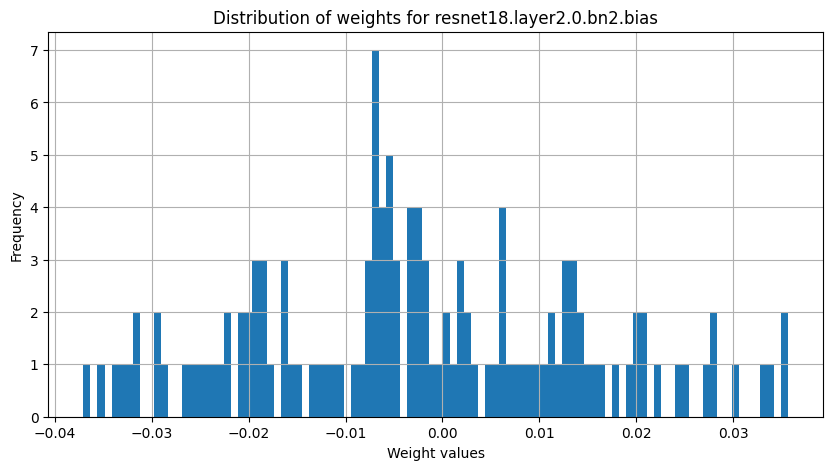

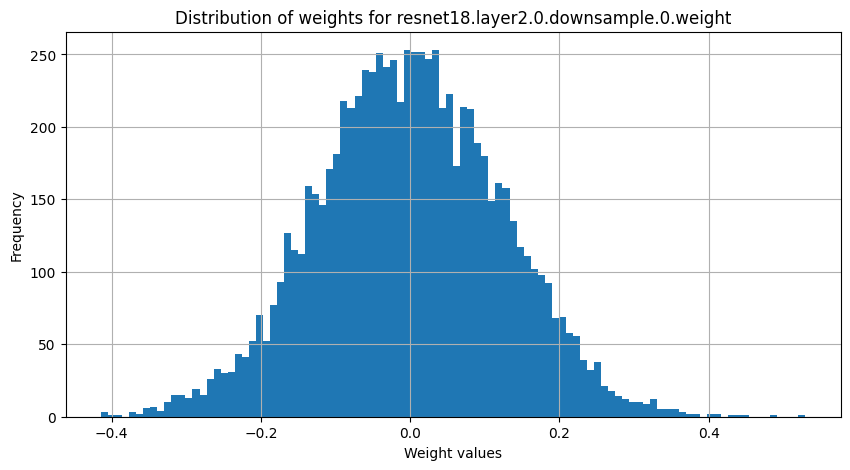

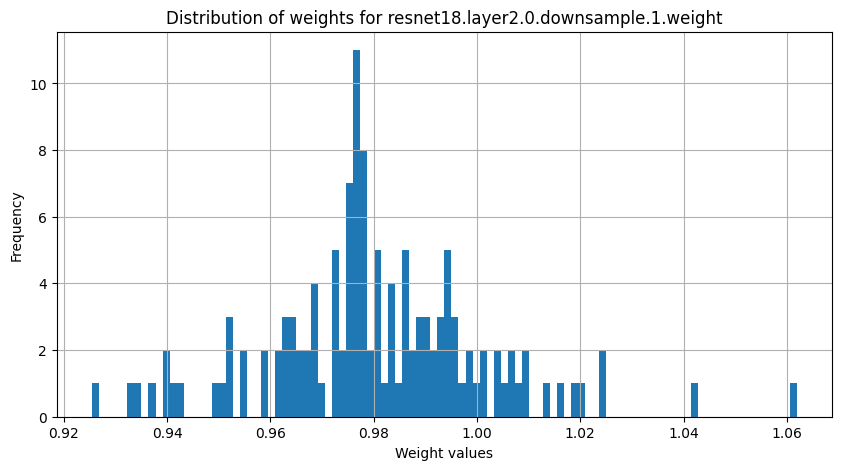

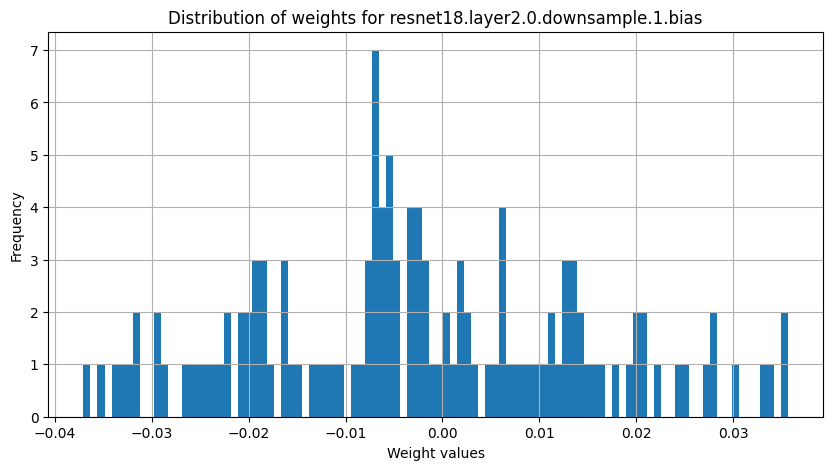

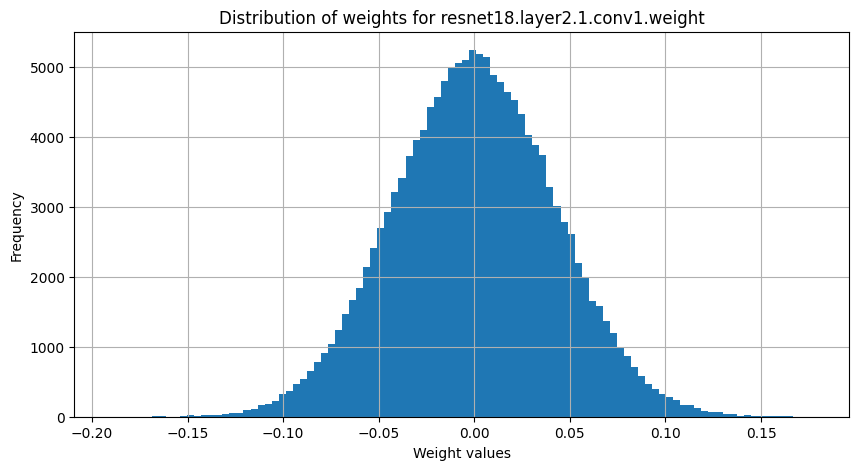

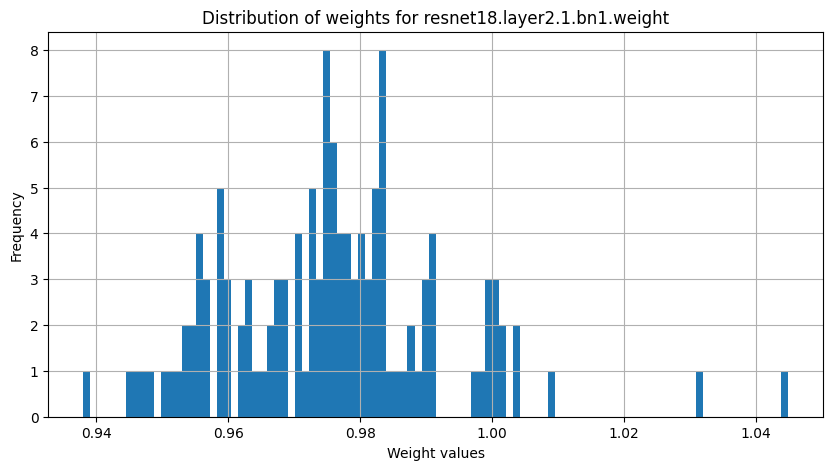

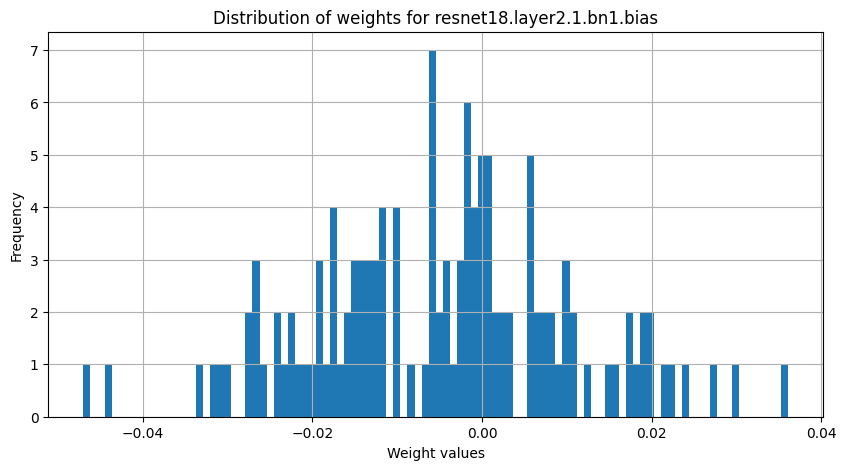

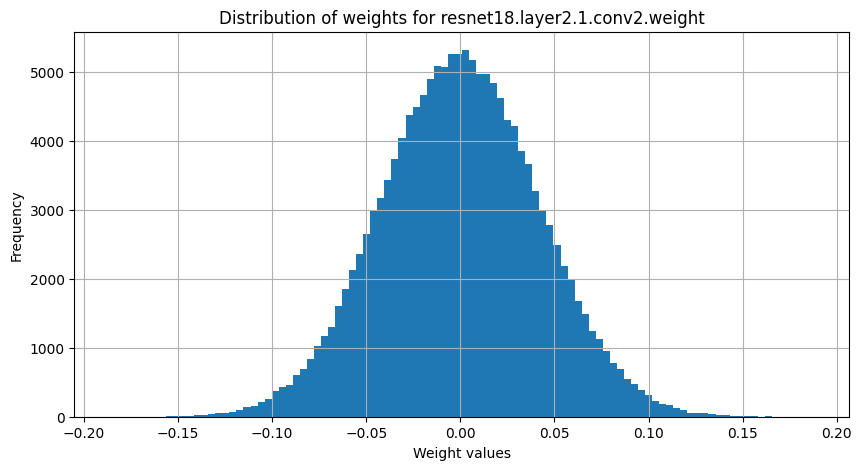

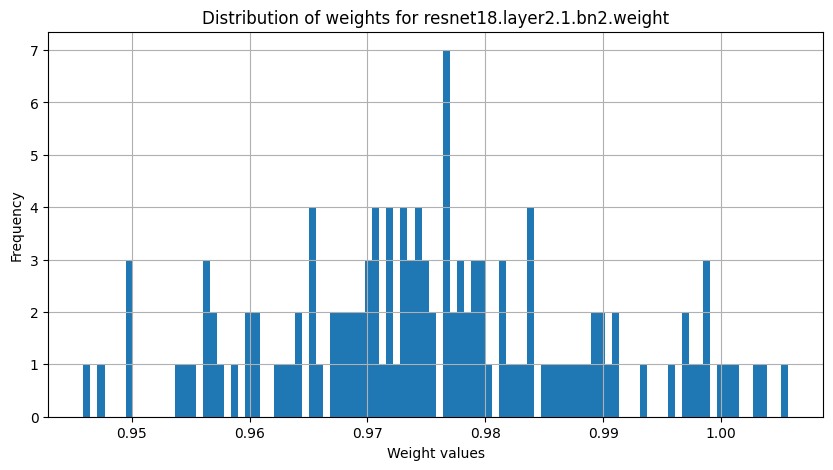

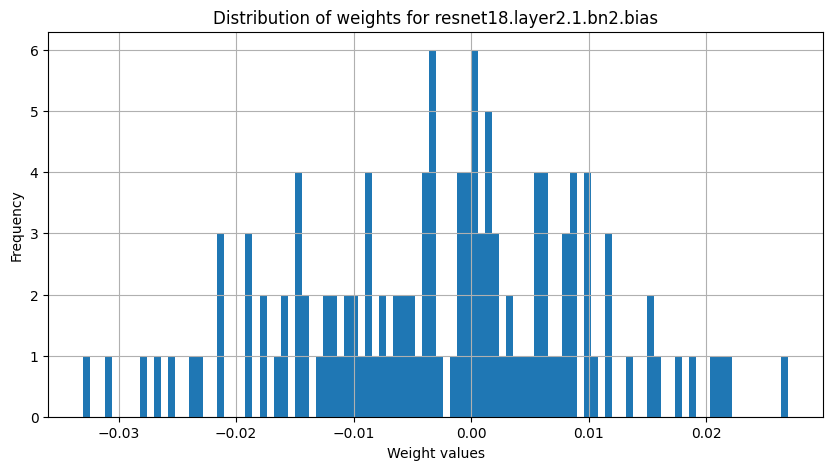

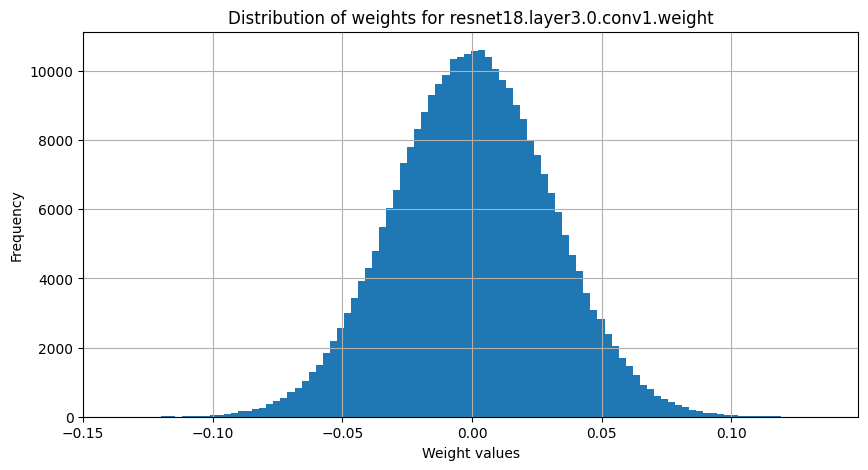

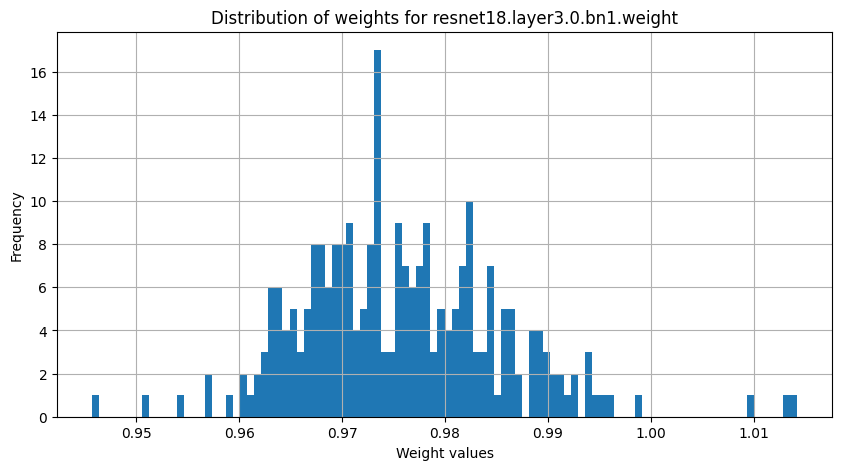

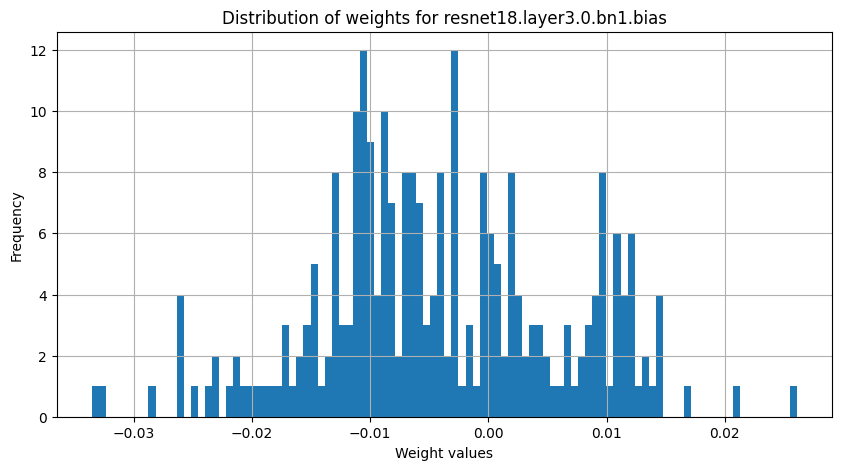

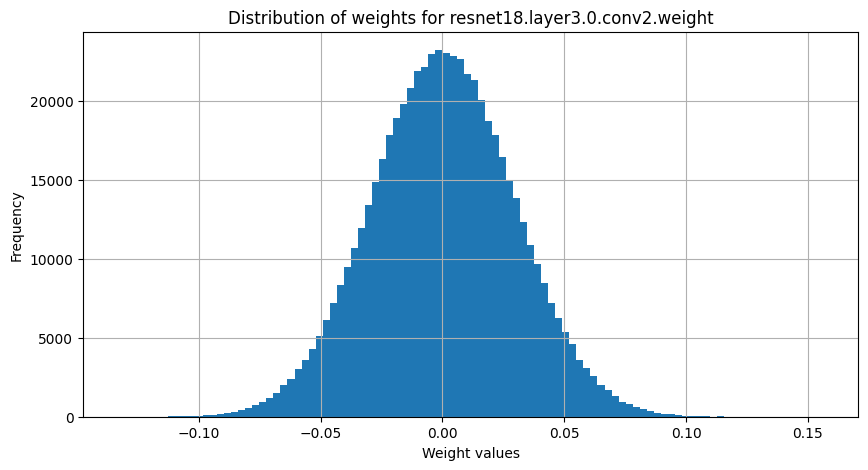

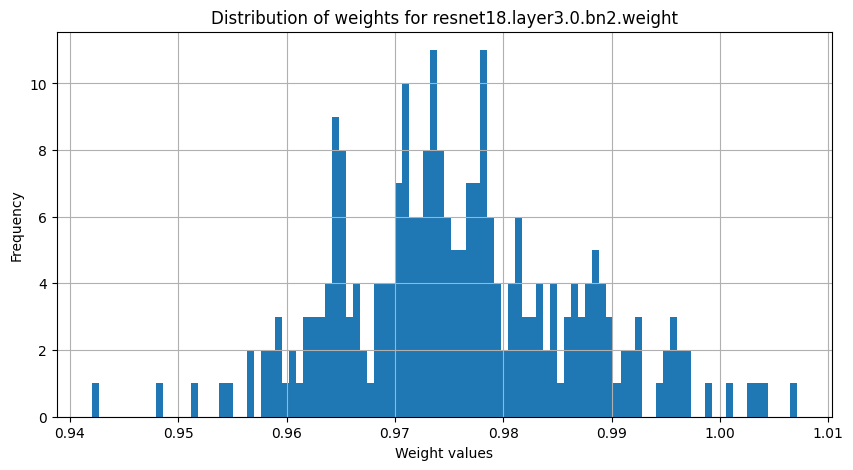

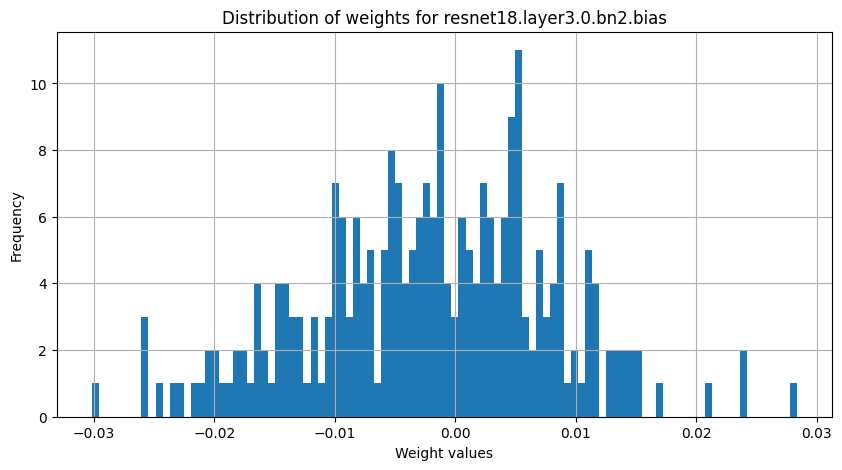

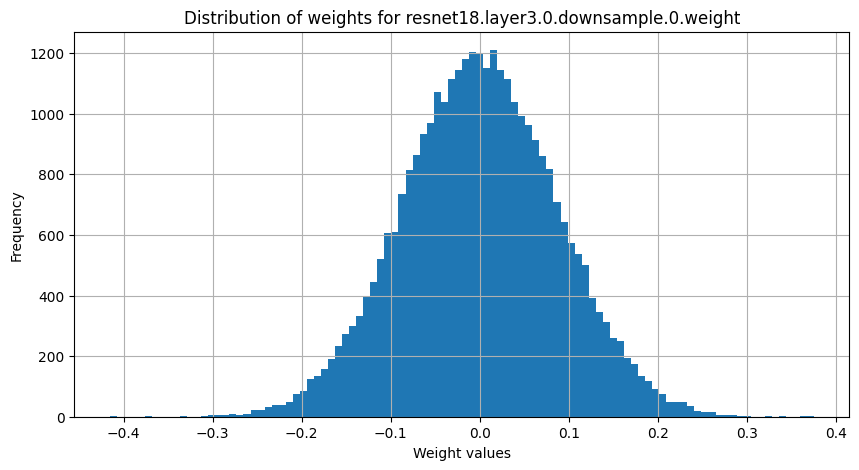

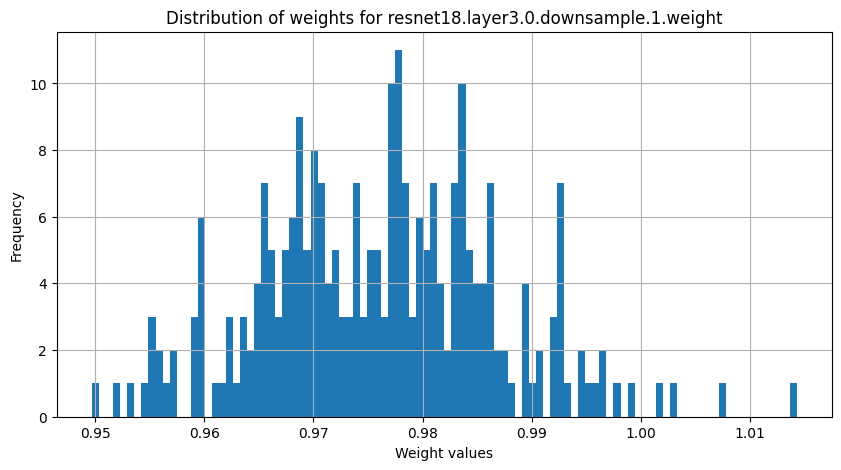

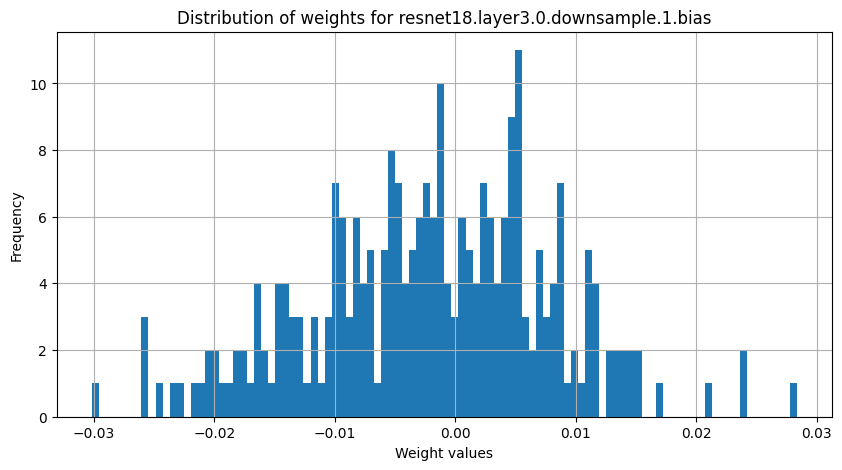

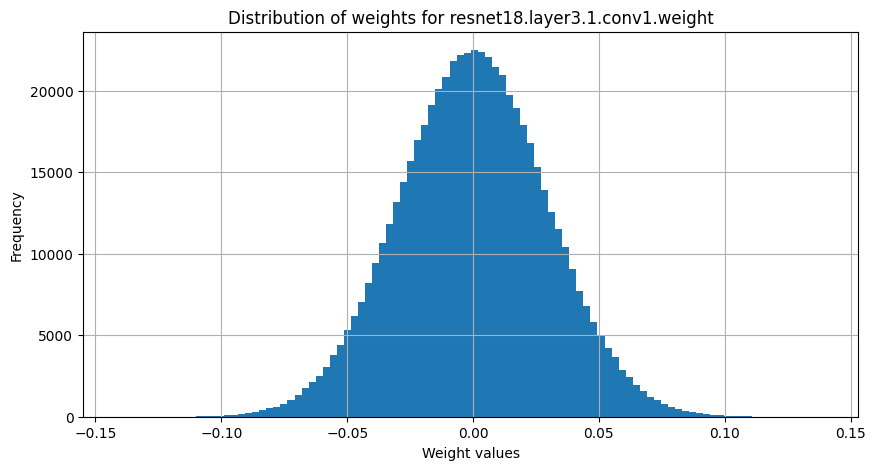

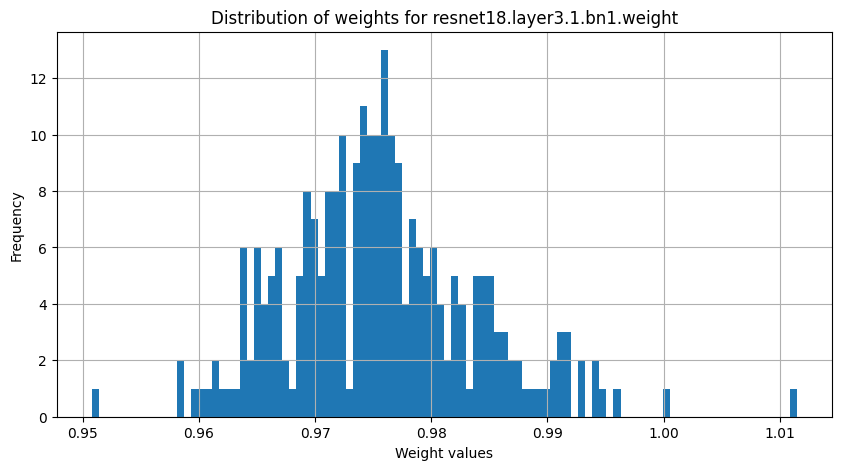

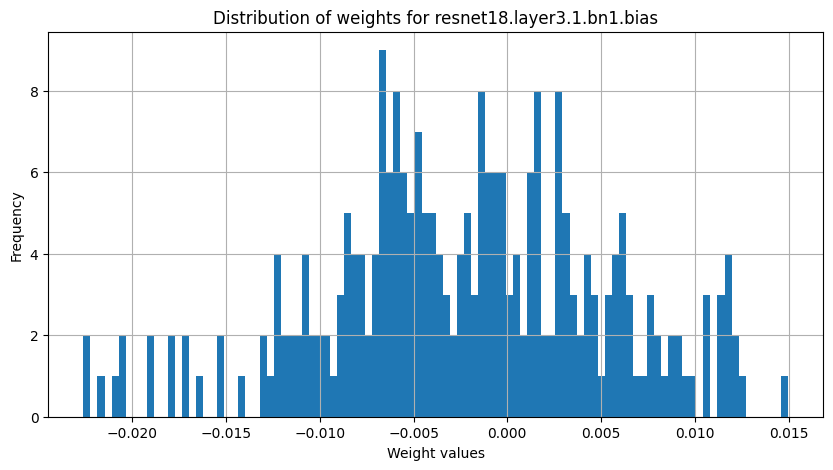

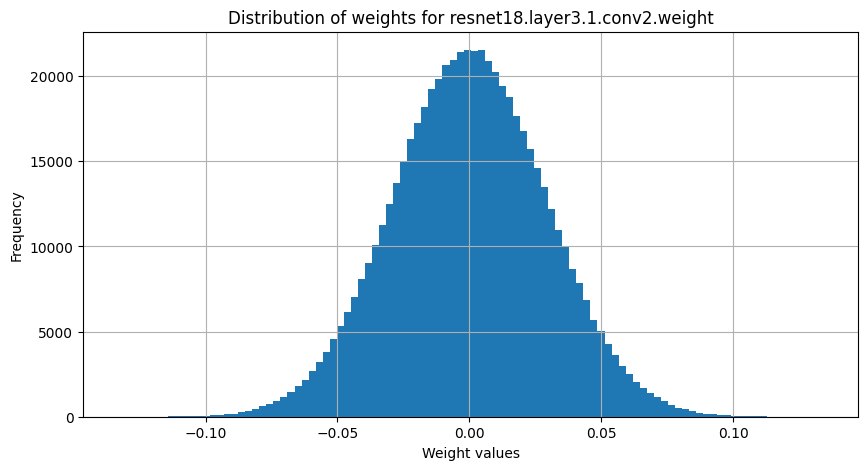

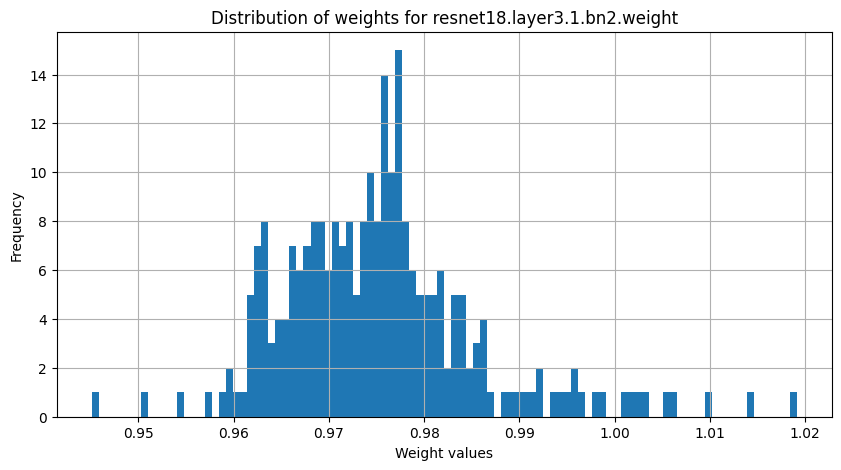

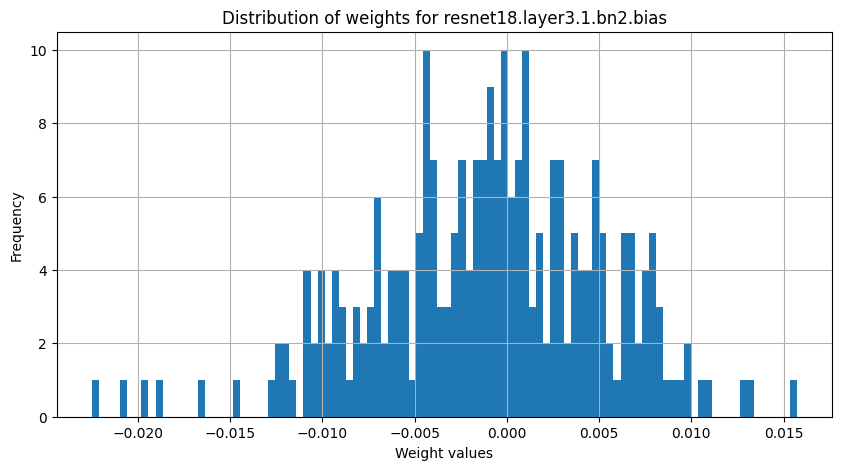

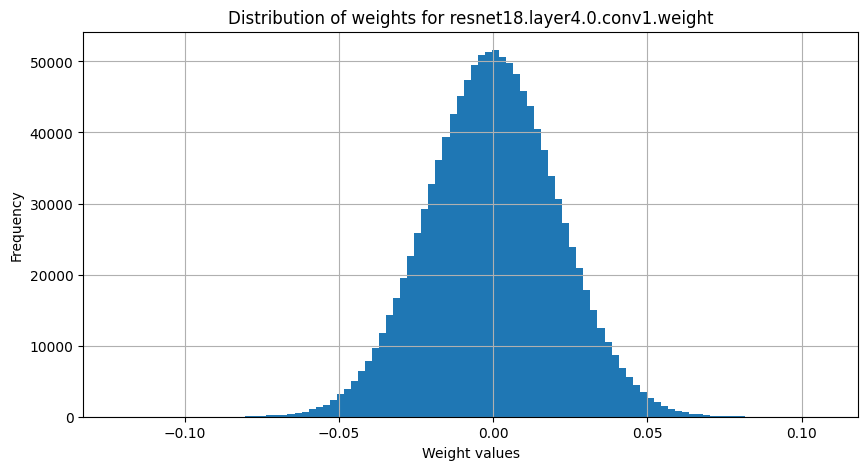

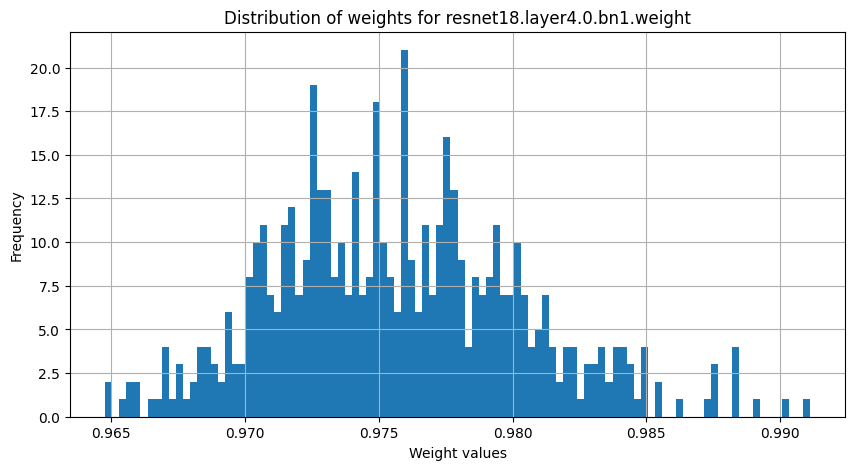

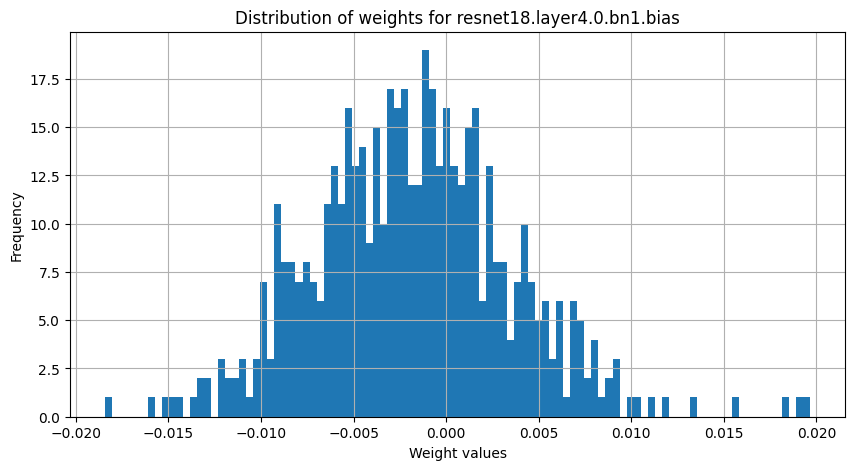

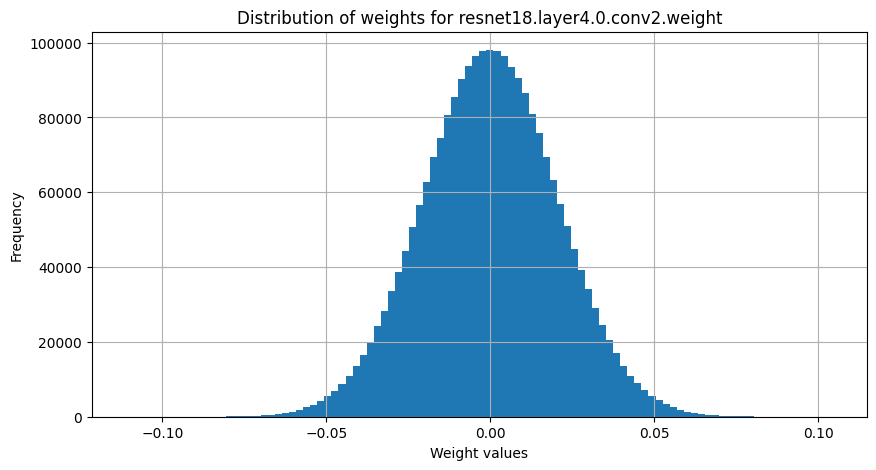

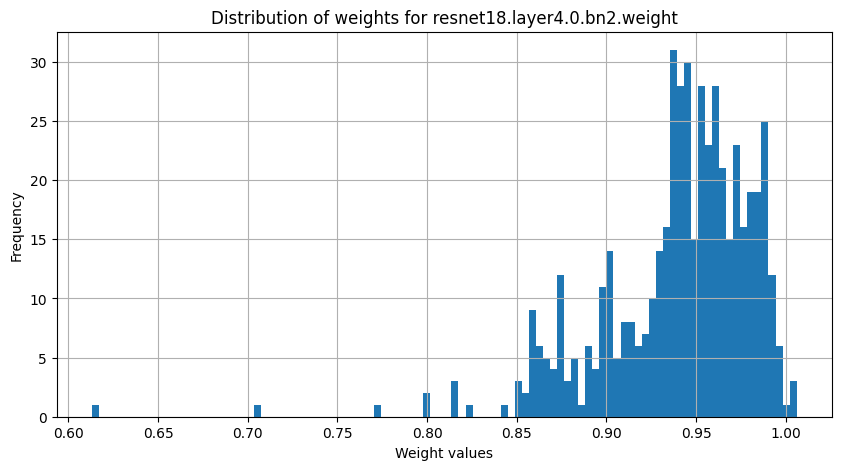

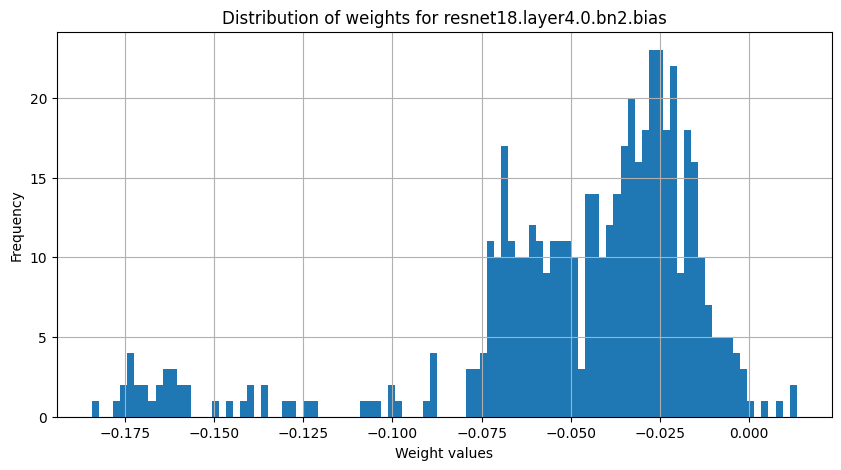

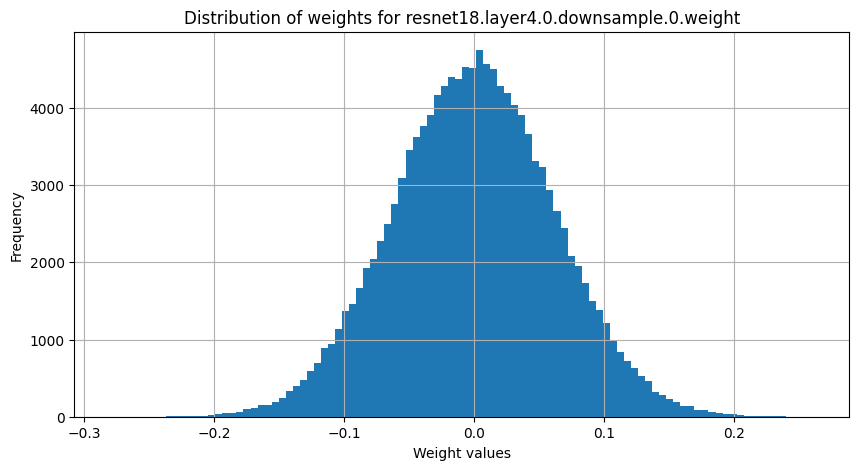

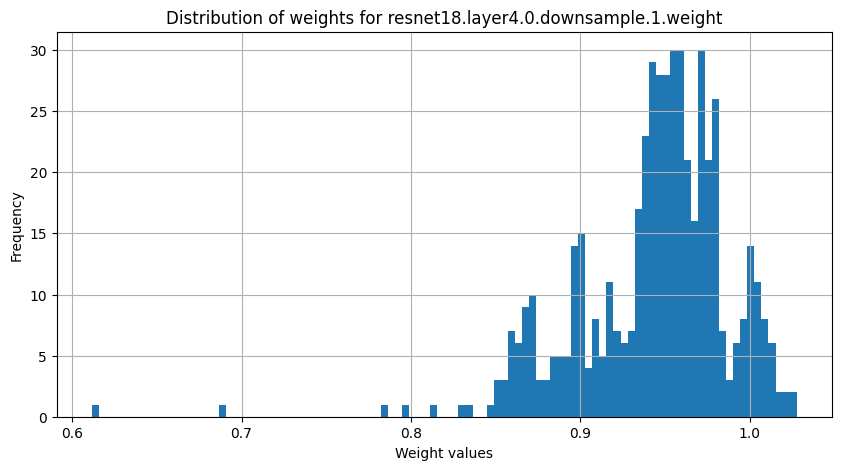

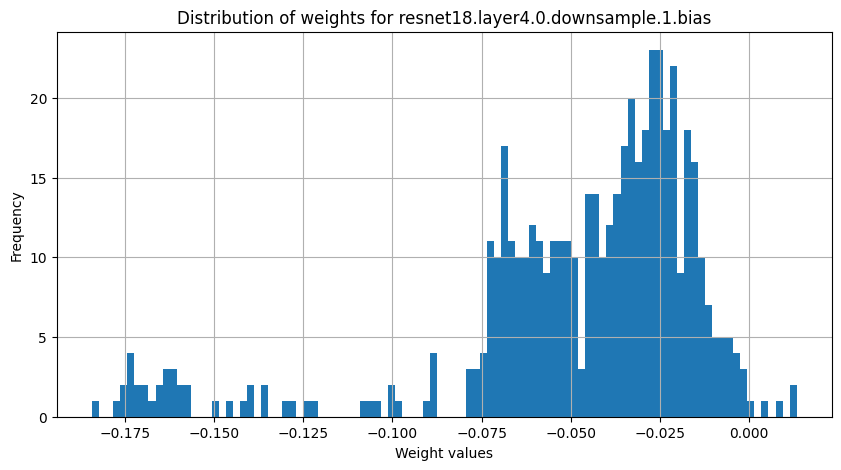

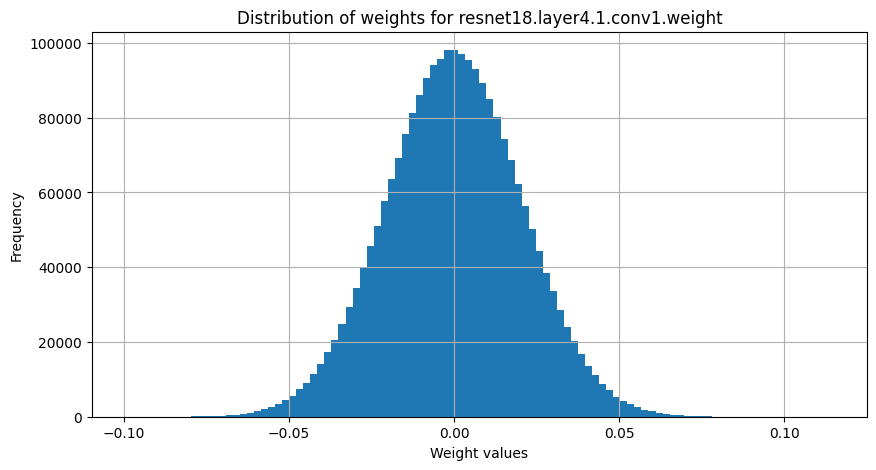

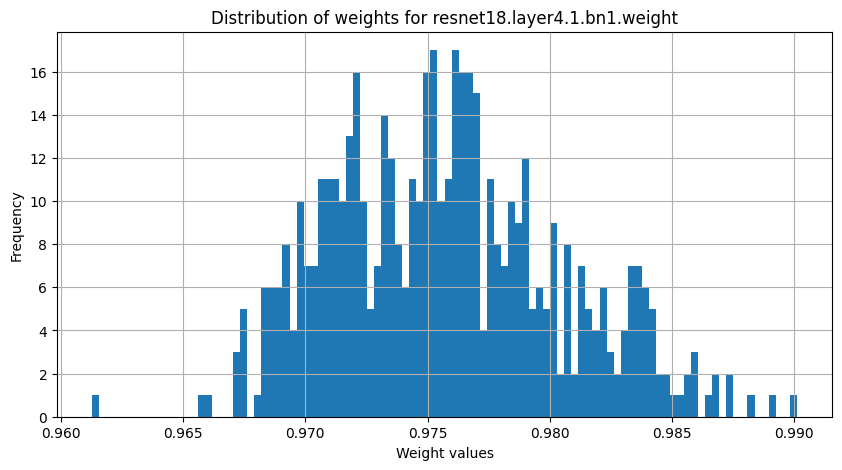

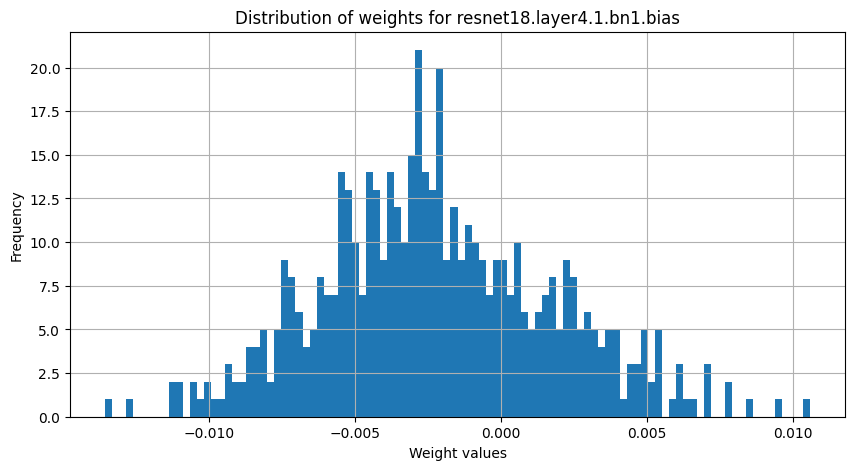

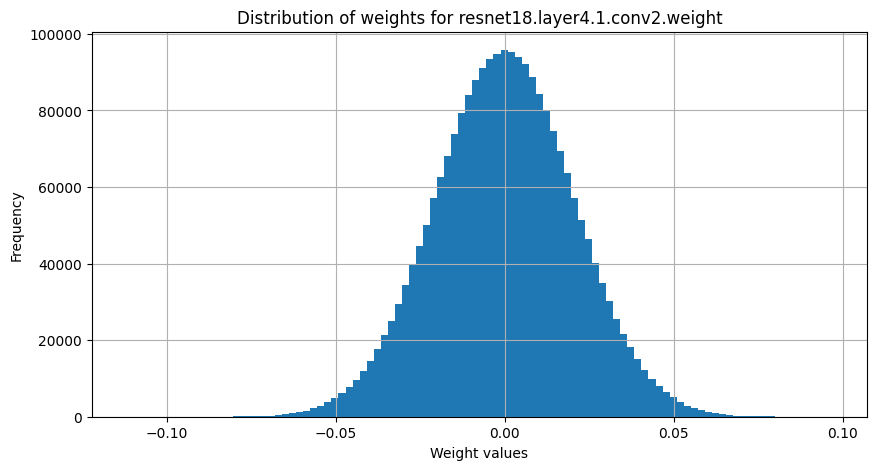

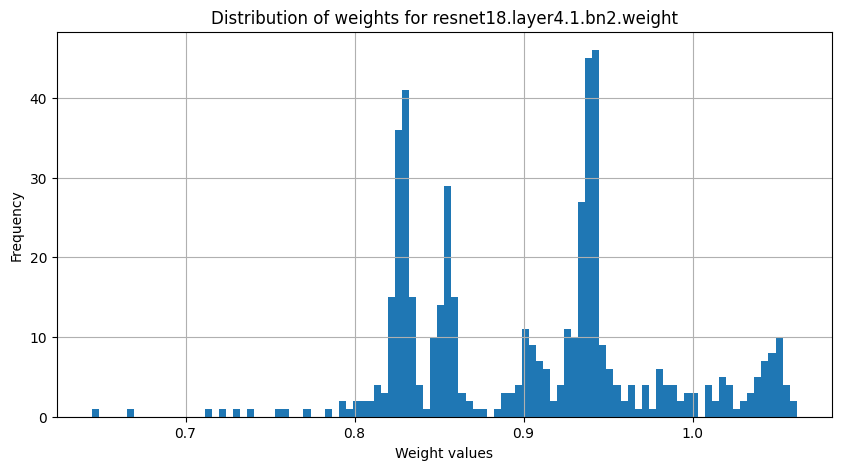

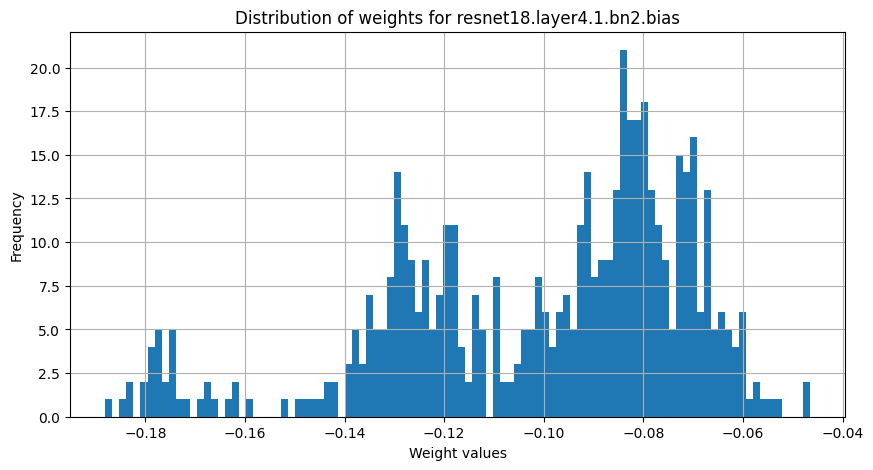

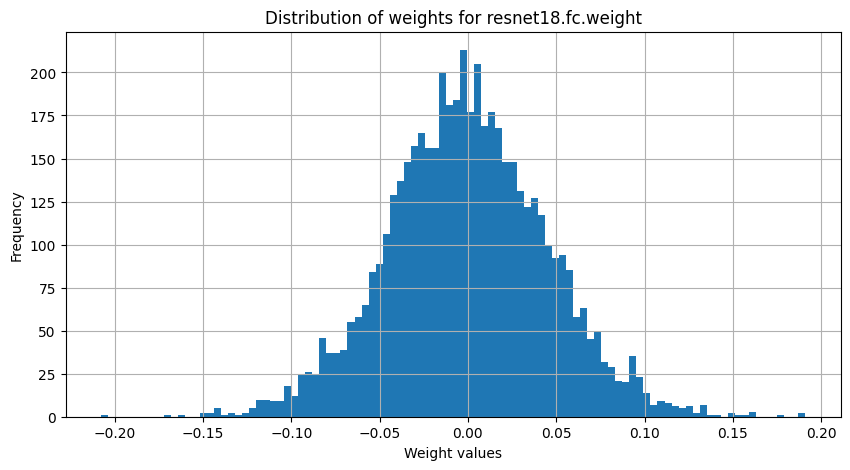

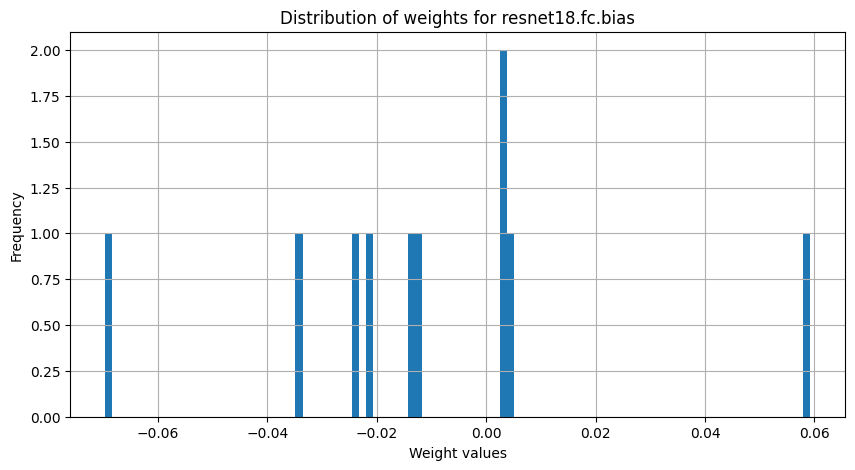

In [8]:
def plot_weight_distribution(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            plt.figure(figsize=(10, 5))
            plt.title(f"Distribution of weights for {name}")
            plt.hist(param.data.cpu().numpy().flatten(), bins=100)
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.show()
plot_weight_distribution(model)

In [5]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {torch.norm(param.data):.4f}")

resnet18.conv1.weight: 9.9841
resnet18.bn1.weight: 7.9025
resnet18.bn1.bias: 0.4211
resnet18.layer1.0.conv1.weight: 11.9426
resnet18.layer1.0.bn1.weight: 7.8128
resnet18.layer1.0.bn1.bias: 0.2313
resnet18.layer1.0.conv2.weight: 11.7958
resnet18.layer1.0.bn2.weight: 7.7958
resnet18.layer1.0.bn2.bias: 0.2054
resnet18.layer1.1.conv1.weight: 11.6816
resnet18.layer1.1.bn1.weight: 7.8097
resnet18.layer1.1.bn1.bias: 0.1867
resnet18.layer1.1.conv2.weight: 11.5544
resnet18.layer1.1.bn2.weight: 7.7363
resnet18.layer1.1.bn2.bias: 0.1599
resnet18.layer2.0.conv1.weight: 11.9438
resnet18.layer2.0.bn1.weight: 11.0407
resnet18.layer2.0.bn1.bias: 0.2002
resnet18.layer2.0.conv2.weight: 16.2169
resnet18.layer2.0.bn2.weight: 10.9889
resnet18.layer2.0.bn2.bias: 0.1940
resnet18.layer2.0.downsample.0.weight: 11.1382
resnet18.layer2.0.downsample.1.weight: 11.0948
resnet18.layer2.0.downsample.1.bias: 0.1940
resnet18.layer2.1.conv1.weight: 16.1984
resnet18.layer2.1.bn1.weight: 11.0402
resnet18.layer2.1.bn1.bias

In [5]:
count = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {torch.norm(param.data):.4f}")
        count += torch.norm(param.data)

print(count)

resnet18.conv1.weight: 9.8421
resnet18.bn1.weight: 8.0017
resnet18.bn1.bias: 0.6670
resnet18.layer1.0.conv1.weight: 11.8414
resnet18.layer1.0.bn1.weight: 7.6199
resnet18.layer1.0.bn1.bias: 0.4097
resnet18.layer1.0.conv2.weight: 11.7206
resnet18.layer1.0.bn2.weight: 7.4228
resnet18.layer1.0.bn2.bias: 0.2968
resnet18.layer1.1.conv1.weight: 11.4897
resnet18.layer1.1.bn1.weight: 7.6158
resnet18.layer1.1.bn1.bias: 0.2748
resnet18.layer1.1.conv2.weight: 11.3751
resnet18.layer1.1.bn2.weight: 7.4234
resnet18.layer1.1.bn2.bias: 0.2078
resnet18.layer2.0.conv1.weight: 11.8333
resnet18.layer2.0.bn1.weight: 10.7678
resnet18.layer2.0.bn1.bias: 0.2659
resnet18.layer2.0.conv2.weight: 16.0075
resnet18.layer2.0.bn2.weight: 10.6751
resnet18.layer2.0.bn2.bias: 0.2699
resnet18.layer2.0.downsample.0.weight: 10.9528
resnet18.layer2.0.downsample.1.weight: 10.9444
resnet18.layer2.0.downsample.1.bias: 0.2699
resnet18.layer2.1.conv1.weight: 15.9238
resnet18.layer2.1.bn1.weight: 10.7672
resnet18.layer2.1.bn1.bias

In [6]:
count = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {torch.norm(param.data):.4f}")
        count += torch.norm(param.data)

print(count)

resnet18.conv1.weight: 9.9841
resnet18.bn1.weight: 7.9025
resnet18.bn1.bias: 0.4211
resnet18.layer1.0.conv1.weight: 11.9426
resnet18.layer1.0.bn1.weight: 7.8128
resnet18.layer1.0.bn1.bias: 0.2313
resnet18.layer1.0.conv2.weight: 11.7958
resnet18.layer1.0.bn2.weight: 7.7958
resnet18.layer1.0.bn2.bias: 0.2054
resnet18.layer1.1.conv1.weight: 11.6816
resnet18.layer1.1.bn1.weight: 7.8097
resnet18.layer1.1.bn1.bias: 0.1867
resnet18.layer1.1.conv2.weight: 11.5544
resnet18.layer1.1.bn2.weight: 7.7363
resnet18.layer1.1.bn2.bias: 0.1599
resnet18.layer2.0.conv1.weight: 11.9438
resnet18.layer2.0.bn1.weight: 11.0407
resnet18.layer2.0.bn1.bias: 0.2002
resnet18.layer2.0.conv2.weight: 16.2169
resnet18.layer2.0.bn2.weight: 10.9889
resnet18.layer2.0.bn2.bias: 0.1940
resnet18.layer2.0.downsample.0.weight: 11.1382
resnet18.layer2.0.downsample.1.weight: 11.0948
resnet18.layer2.0.downsample.1.bias: 0.1940
resnet18.layer2.1.conv1.weight: 16.1984
resnet18.layer2.1.bn1.weight: 11.0402
resnet18.layer2.1.bn1.bias